In [1]:

import datacleaner as dtclean
import dataexplore as dtexp
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools
import matplotlib.pyplot as plt
# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import warnings

warnings.filterwarnings('ignore')

# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

# Visualizando o dataframe

In [2]:
df_432_time_cli = dtclean.get_Dataframes_time(432,'c')
df_432_time_cli.reset_index(inplace=True)
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

iplot(dtexp.getTableDataframe(df_432_time_cli))

# Análise dos Dados

#### Dados negativos

In [3]:
df_432_time_cli.loc[df_432_time_cli['y'] < 0]

ds  y
548  2020-03-20 21:30:00 -1
890  2020-04-02 21:30:00 -1
1320 2020-04-19 09:00:00 -1
2141 2020-05-20 22:00:00 -1
2170 2020-05-21 22:00:00 -1

### Remoção dos dados negativos

In [4]:
df_432_time_cli = df_432_time_cli.loc[df_432_time_cli['y'] > 0]


In [5]:
iplot(dtexp.getScatterPlot(df_432_time_cli,title='Clientes/hora (março-maio de 2020)'))

In [6]:
df_new = dtexp.date_features(df_432_time_cli)
trace=go.Table(header=dict(values=list(df_new.columns)),
               cells=dict(values=[df_new.mes,
                                  df_new.diames,
                                  df_new.semana,
                                  df_new.diasemana,
                                  df_new.hora,
                                  df_new.minuto, df_new.y]))

data=[trace]
fig=go.Figure(data=data)
iplot(fig)

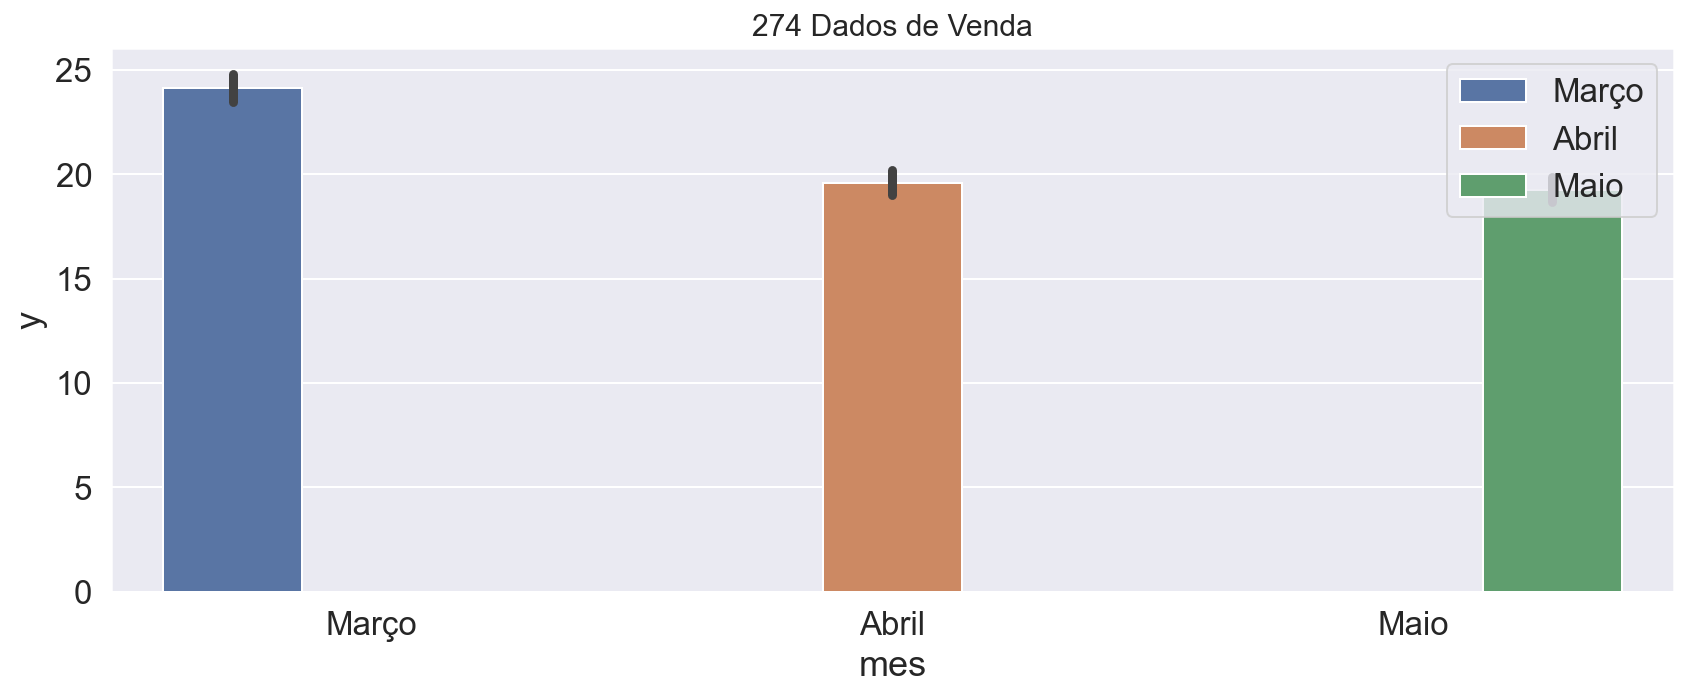

In [7]:
fig, ax = plt.subplots(figsize=(14,5))
plt = dtexp.getDataframeFeatures(df_new,fig, ax)
plt.show()

Text(0.5, 1.0, 'Total Clientes Por Dia da Semana')

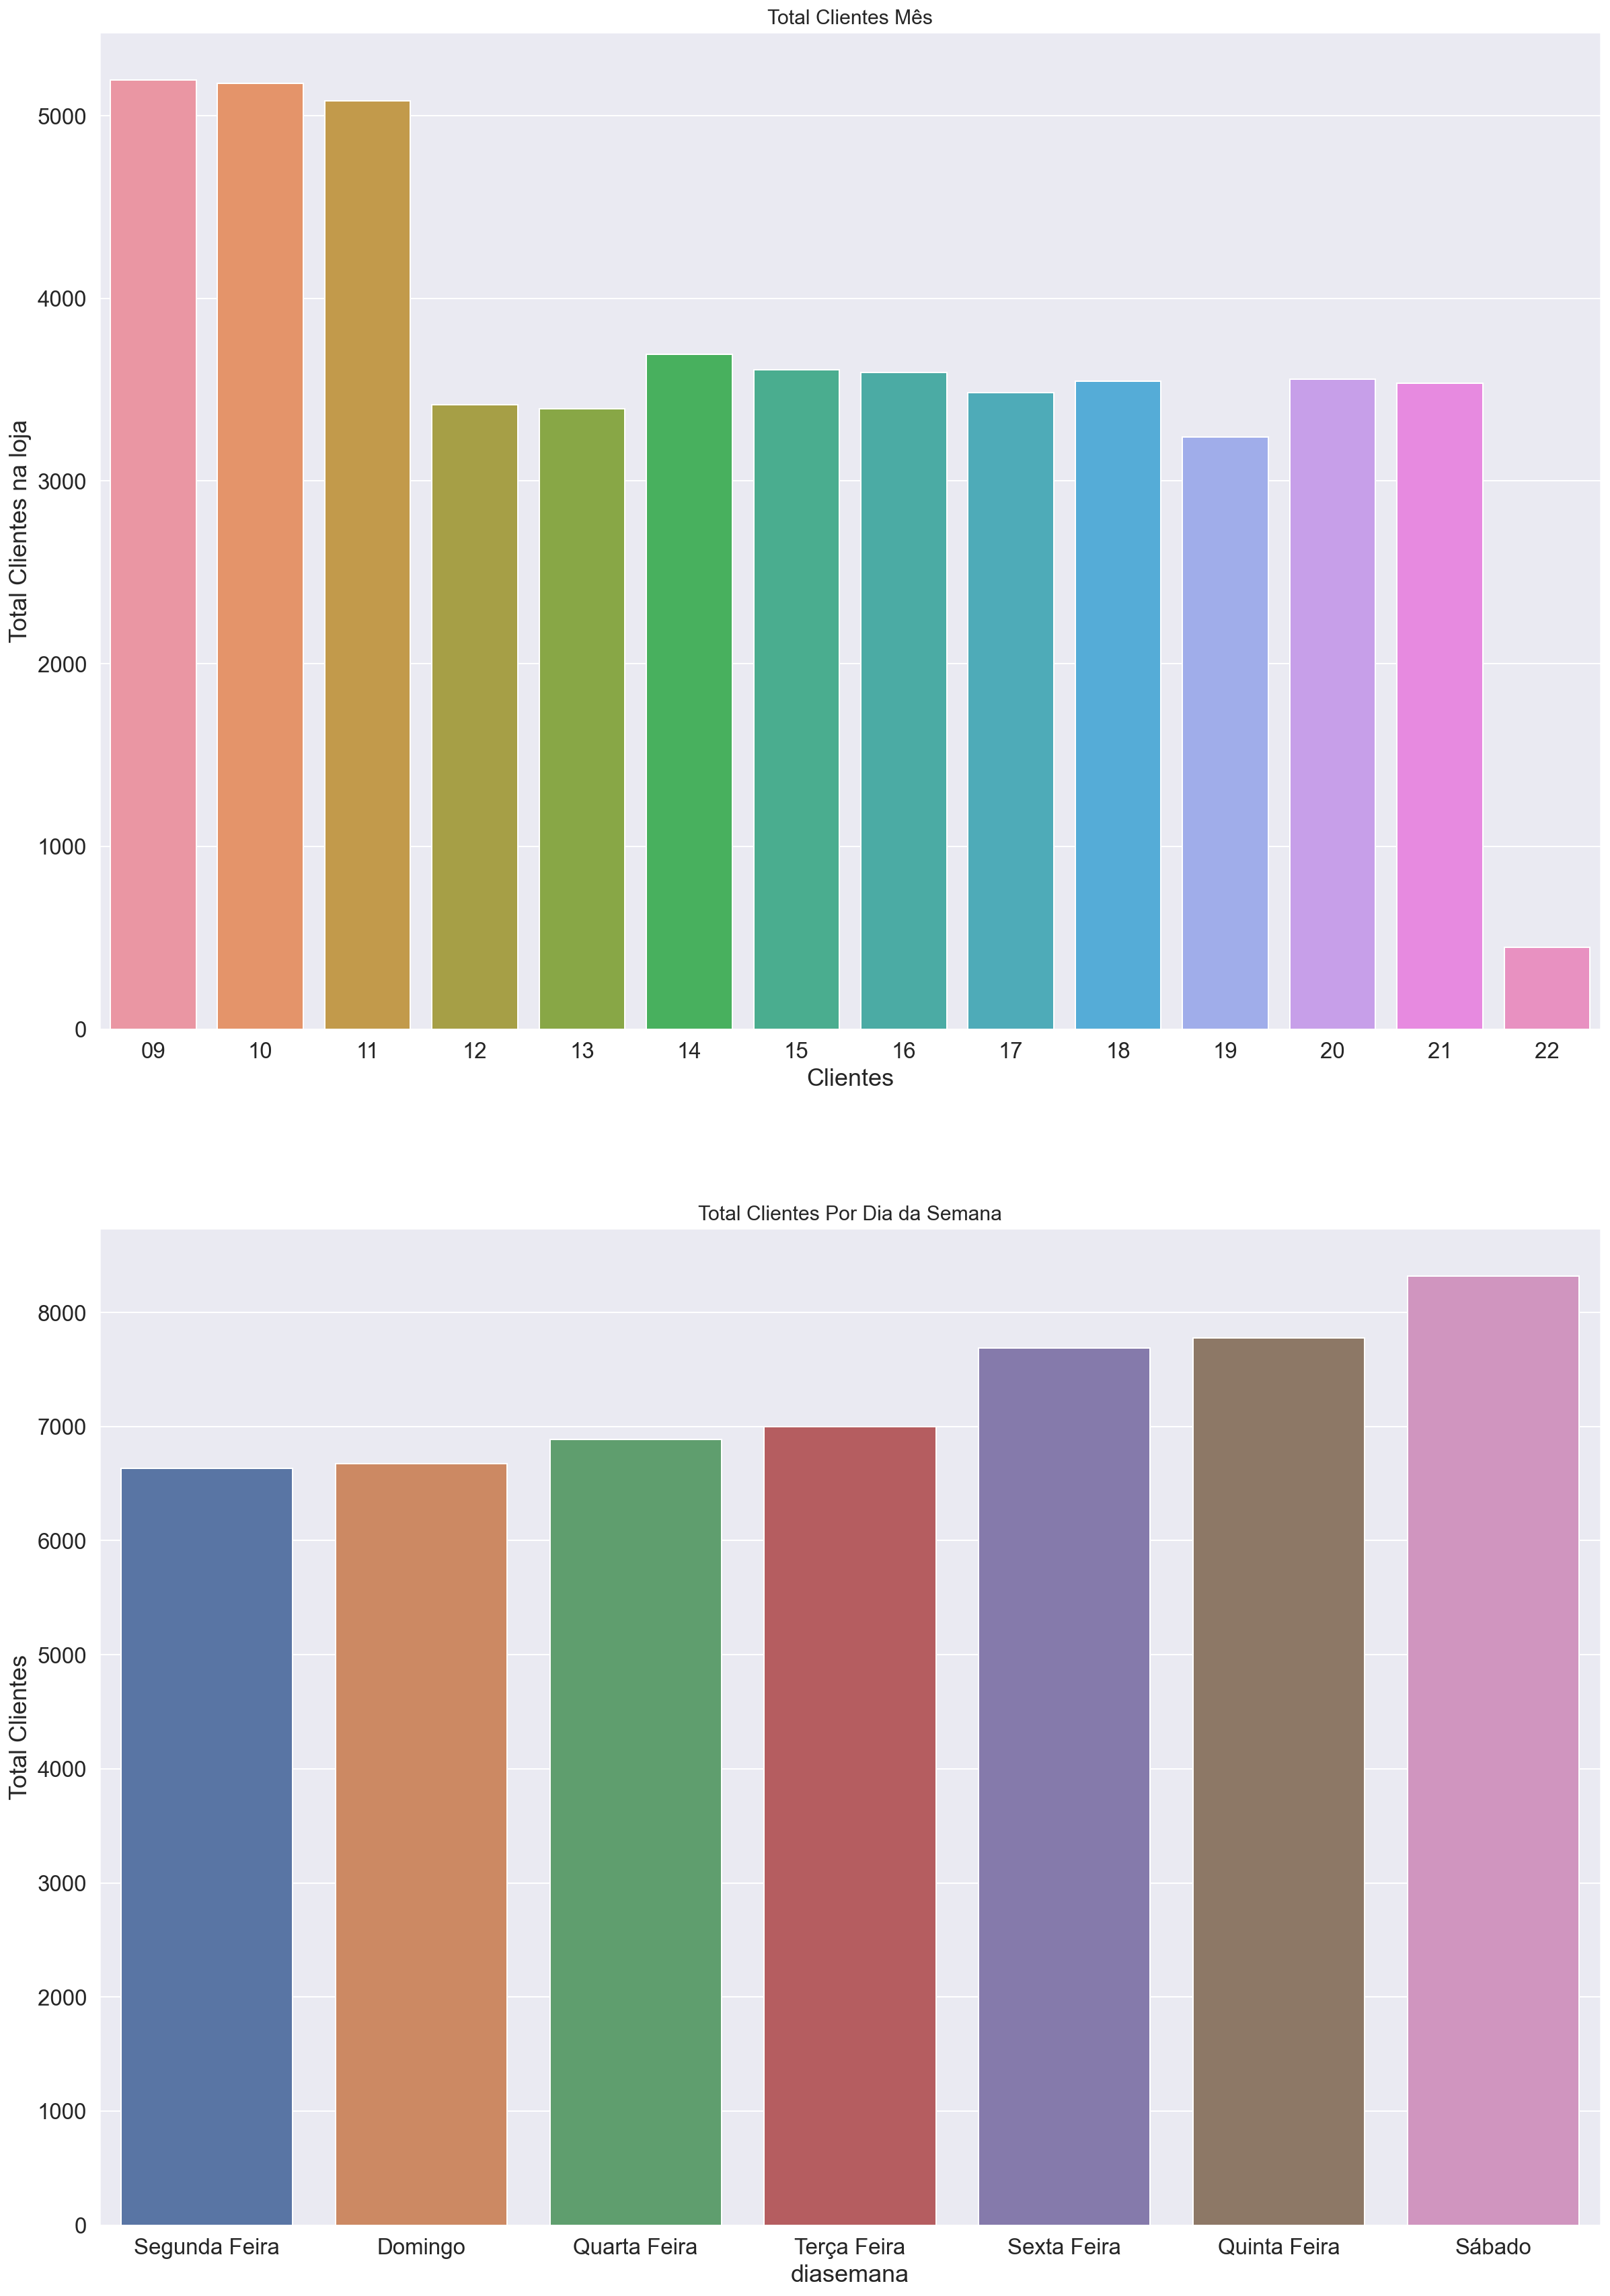

In [8]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,30)

mesAgregado = pd.DataFrame(df_new.groupby("semana")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=mesAgregado,x="semana",y="y",ax=ax1)
ax1.set(xlabel='Clientes', ylabel='Total Clientes na loja')
ax1.set_title("Total Clientes Mês",fontsize=15)

semanaAgregada = pd.DataFrame(df_new.groupby("diasemana")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=semanaAgregada,x="diasemana",y="y",ax=ax2)
ax2.set(xlabel='diasemana', ylabel='Total Clientes')
ax2.set_title("Total Clientes Por Dia da Semana",fontsize=15)

In [9]:
df_432_cli_treino, df_432_cli_teste = dtexp.configura_dataframe_treino_teste(df_432_time_cli)
df_432_cli_treino['cap'] = 67*2
df_432_cli_teste['cap'] = 67*2
df_432_cli_treino['floor'] = 1.3
df_432_cli_teste['floor'] = 1.3
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_432_cli_treino.shape))
print('Shape dataframe de teste --> {}'.format(df_432_cli_teste.shape))
print('-'*60)

------------------------------------------------------------
Shape dataframe de treino --> (2219, 4)
Shape dataframe de teste --> (203, 4)
------------------------------------------------------------


# Visualizando o montante de dados para os datasets de treino e de teste

In [10]:
iplot(dtexp.viewCompareDataframes(df_432_cli_treino,
                                   df_432_cli_teste,
                                   title='Montante de dados de qtd clientes em Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [11]:
prophet = Prophet()
prophet.fit(df_432_cli_treino)
future_cli = prophet.make_future_dataframe(periods=7, freq='D')
future_cli['cap'] = 67*2
future_cli['floor'] = 1
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_cli['ds'] = pd.to_datetime(future_cli['ds'])
future_cli = future_cli.set_index(pd.DatetimeIndex(future_cli['ds']))
future_cli = future_cli.between_time('08:00','21:00')

forecast_cli = prophet.predict(future_cli)
trace_forecast=go.Table(header=dict(values=list(forecast_cli[['ds','yhat','yhat_lower','yhat_upper']])),
               cells=dict(values=[forecast_cli.ds,
                                  forecast_cli.yhat,
                                  forecast_cli.yhat_lower,
                                  forecast_cli.yhat_upper]))

data=[trace_forecast]
fig_forecast=go.Figure(data=data)
iplot(fig_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


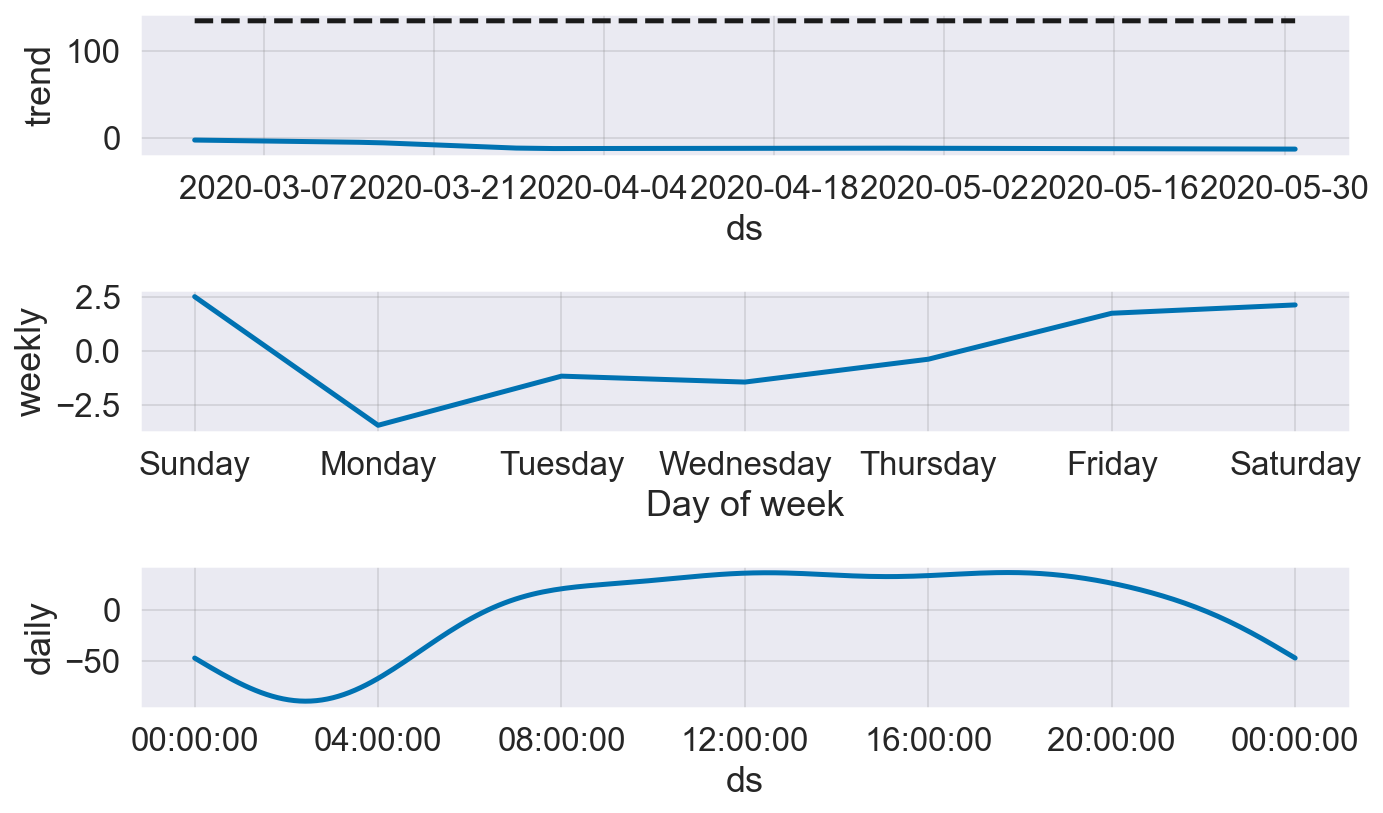

In [12]:
# componentes

fig = prophet.plot_components(forecast_cli, figsize=(10,6))

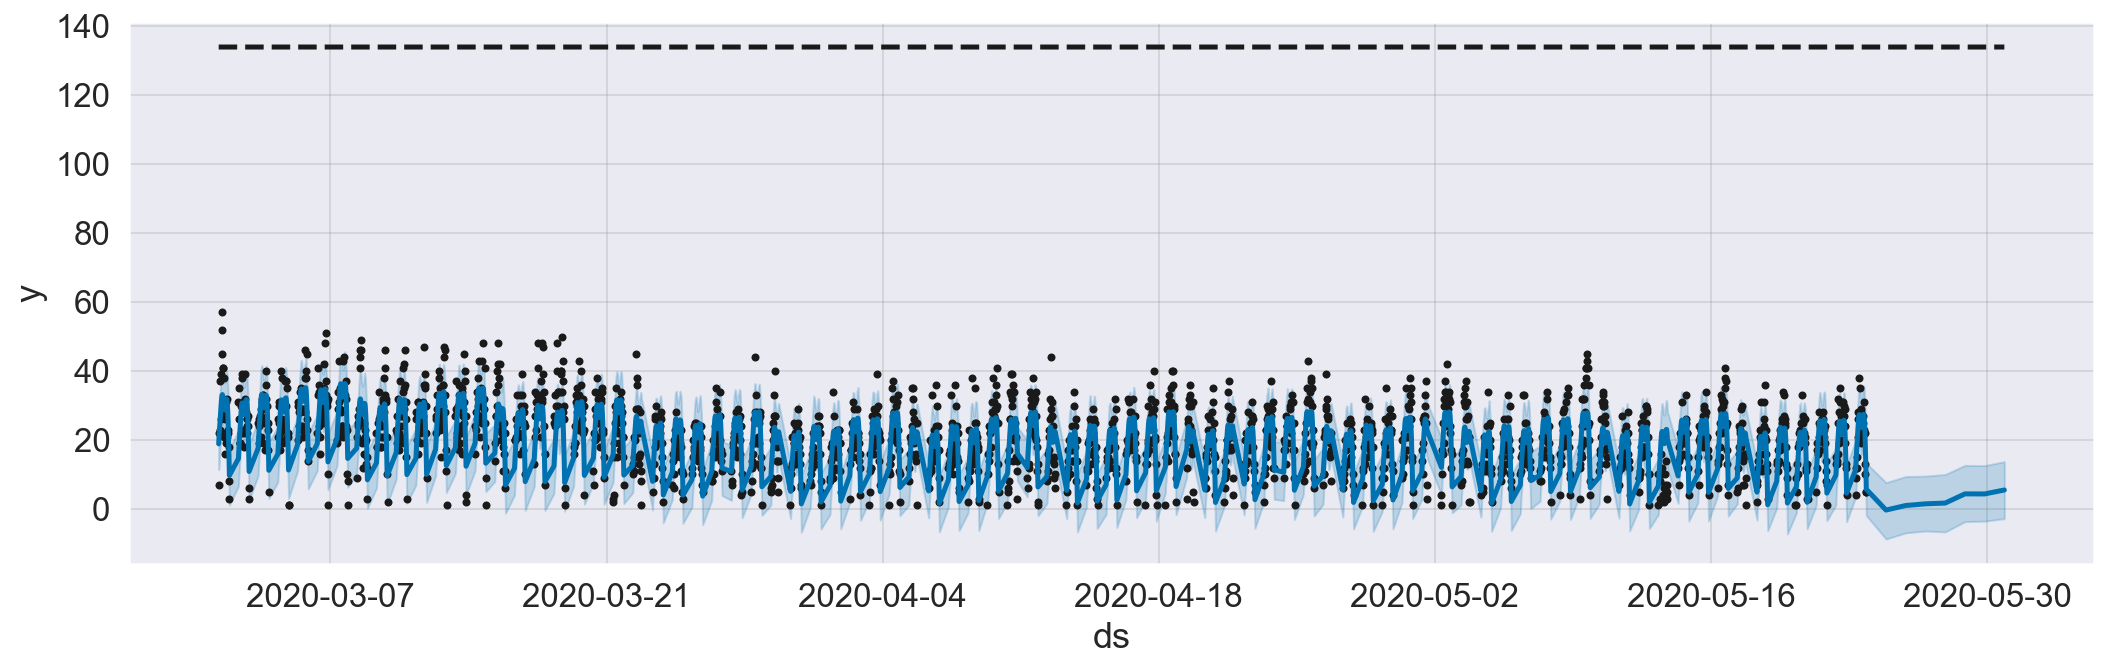

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_cli,ax=ax)
plt.show()

In [14]:
df_432_cli_teste_forecast = prophet.predict(df_432_cli_teste)
iplot(dtexp.viewDataframeAsTable(df_432_cli_teste_forecast))

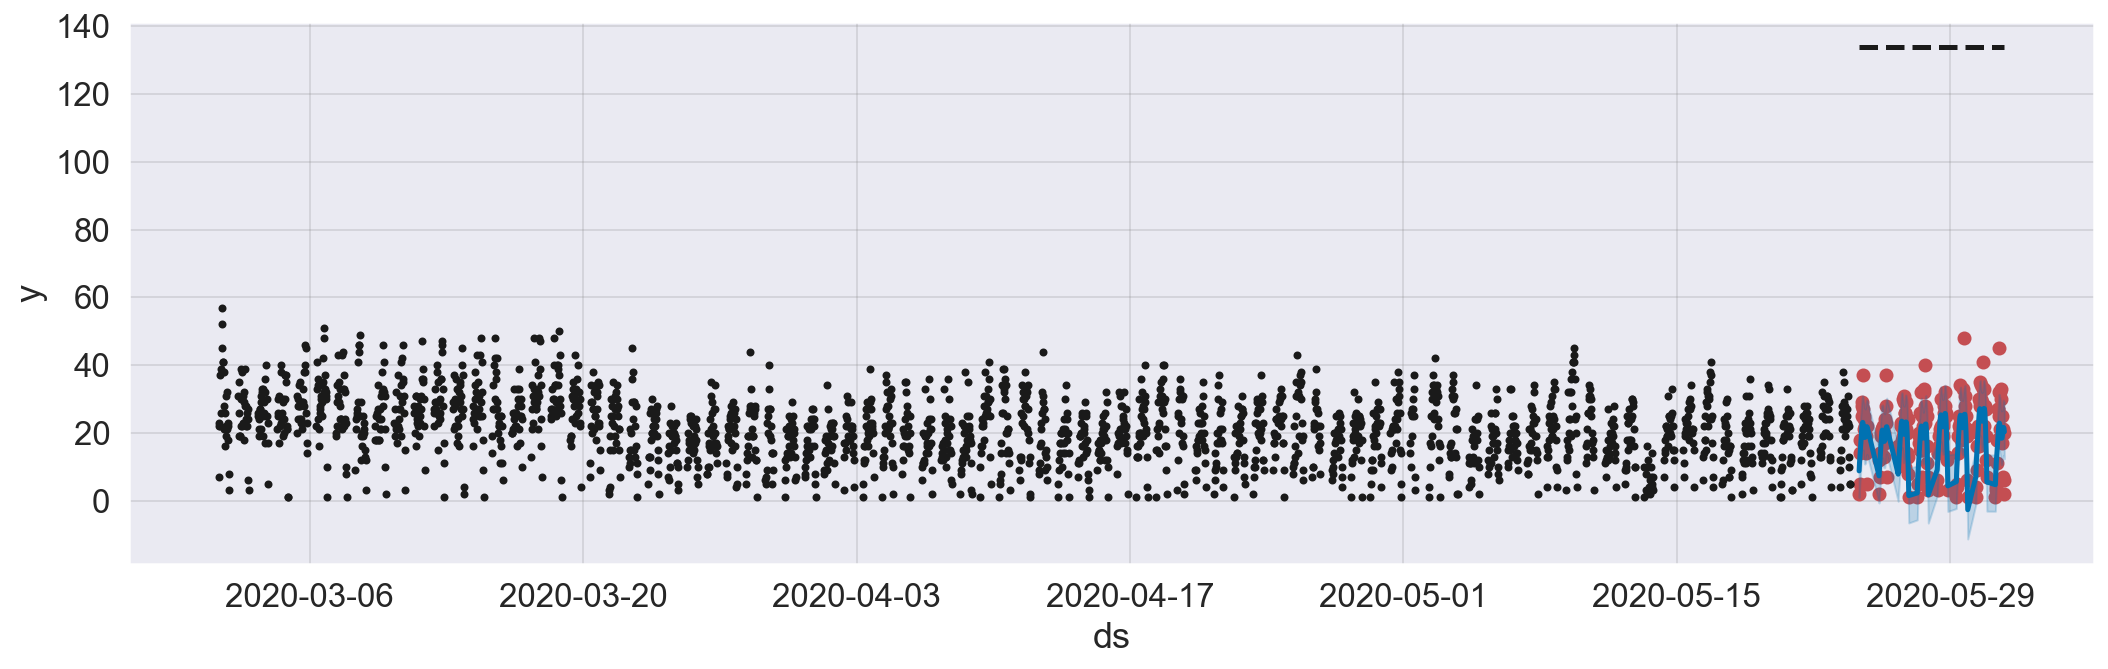

In [15]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_432_cli_teste.ds,df_432_cli_teste['y'], color='r')
fig = prophet.plot(df_432_cli_teste_forecast,ax=ax)
plt.show()


# Comparação entre os clientes previstos e real


In [16]:
iplot(dtexp.viewCompareDataframes(df_432_cli_teste,
                                   df_432_cli_teste_forecast,
                                   title='Qtd Clientes (previsão) vs Qtd Clientes (real)',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

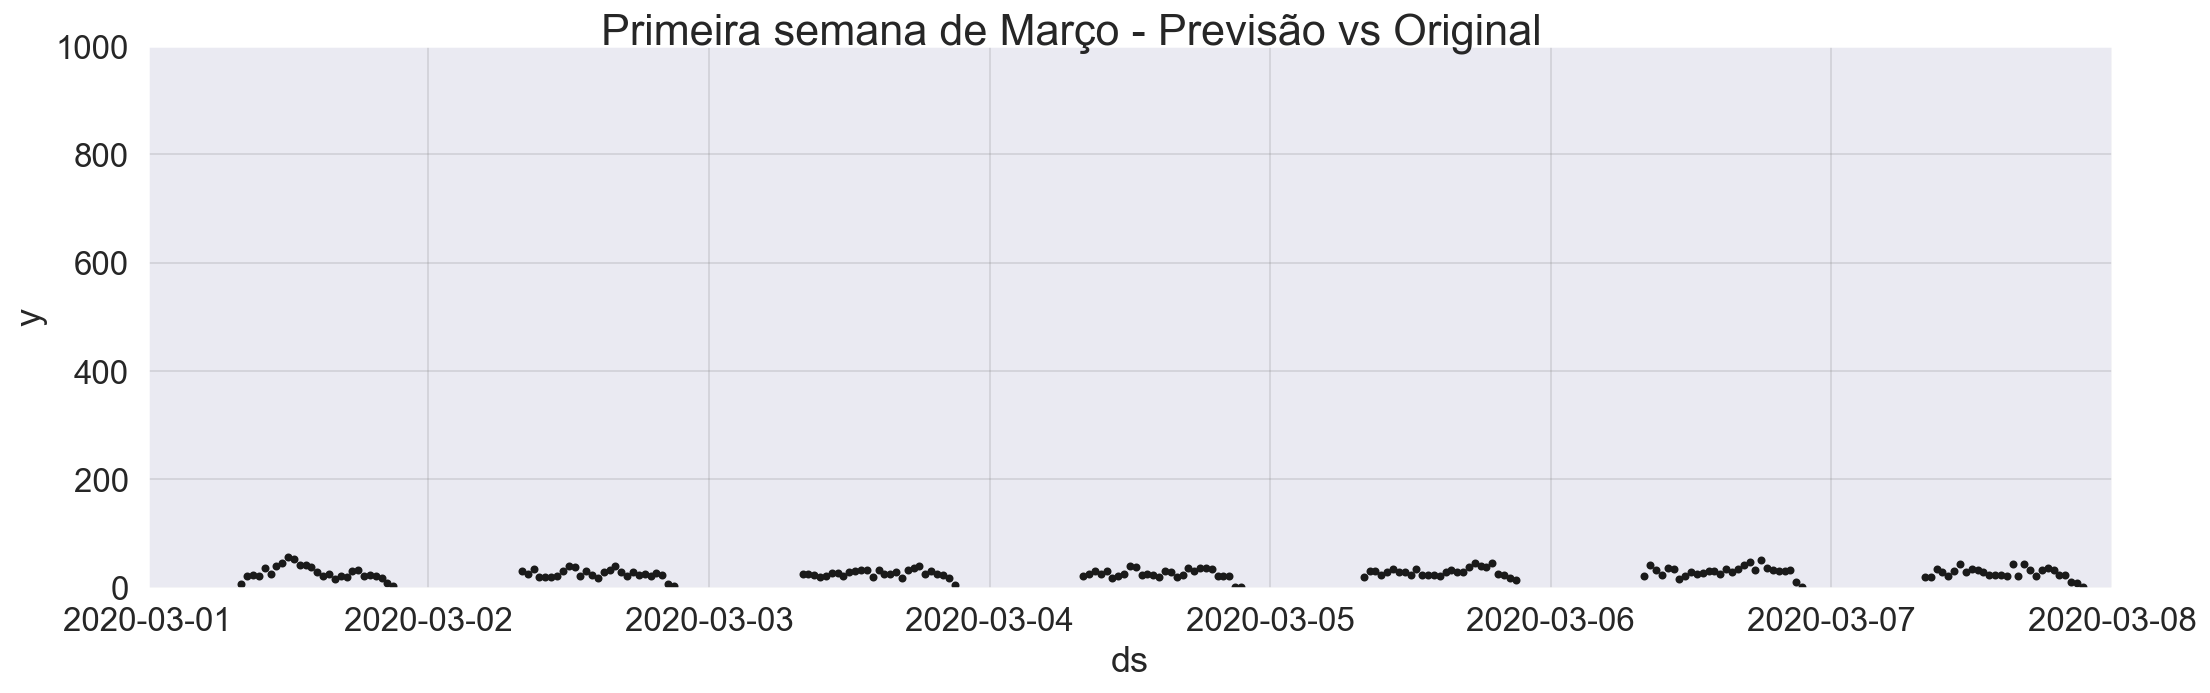

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_432_cli_teste.ds, df_432_cli_teste['y'], color='r')
fig = prophet.plot(df_432_cli_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-03-01', upper='2020-03-08')
ax.set_ylim(0, 1000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [18]:
mape_sem_feriados = dtexp.mean_absolute_percentage_error(df_432_cli_teste['y'],df_432_cli_teste_forecast['yhat'])
print("MAPE",round(mape_sem_feriados,4))

MAPE 48.3961


# Definindo o cap e criando novo modelo com os feriados

In [19]:
# definindo o cap (carrying capacity)
df_432_cli_treino['cap'] = 67*2
df_432_cli_treino['floor'] = 1
df_432_cli_treino.reset_index(drop=True)
feriados = dtclean.get_Holiday()

In [20]:
prophet_feriados = Prophet(holidays=feriados)

prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_432_cli_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em horas (os dados estão em horas)
future_feriados = prophet_feriados.make_future_dataframe(freq='D', periods=8)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_feriados['ds'] = pd.to_datetime(future_feriados['ds'])
future_feriados = future_feriados.set_index(pd.DatetimeIndex(future_feriados['ds']))
future_feriados = future_feriados.between_time('08:00','21:00')
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)
iplot(dtexp.viewDataframeAsTable(forecast_feriados))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


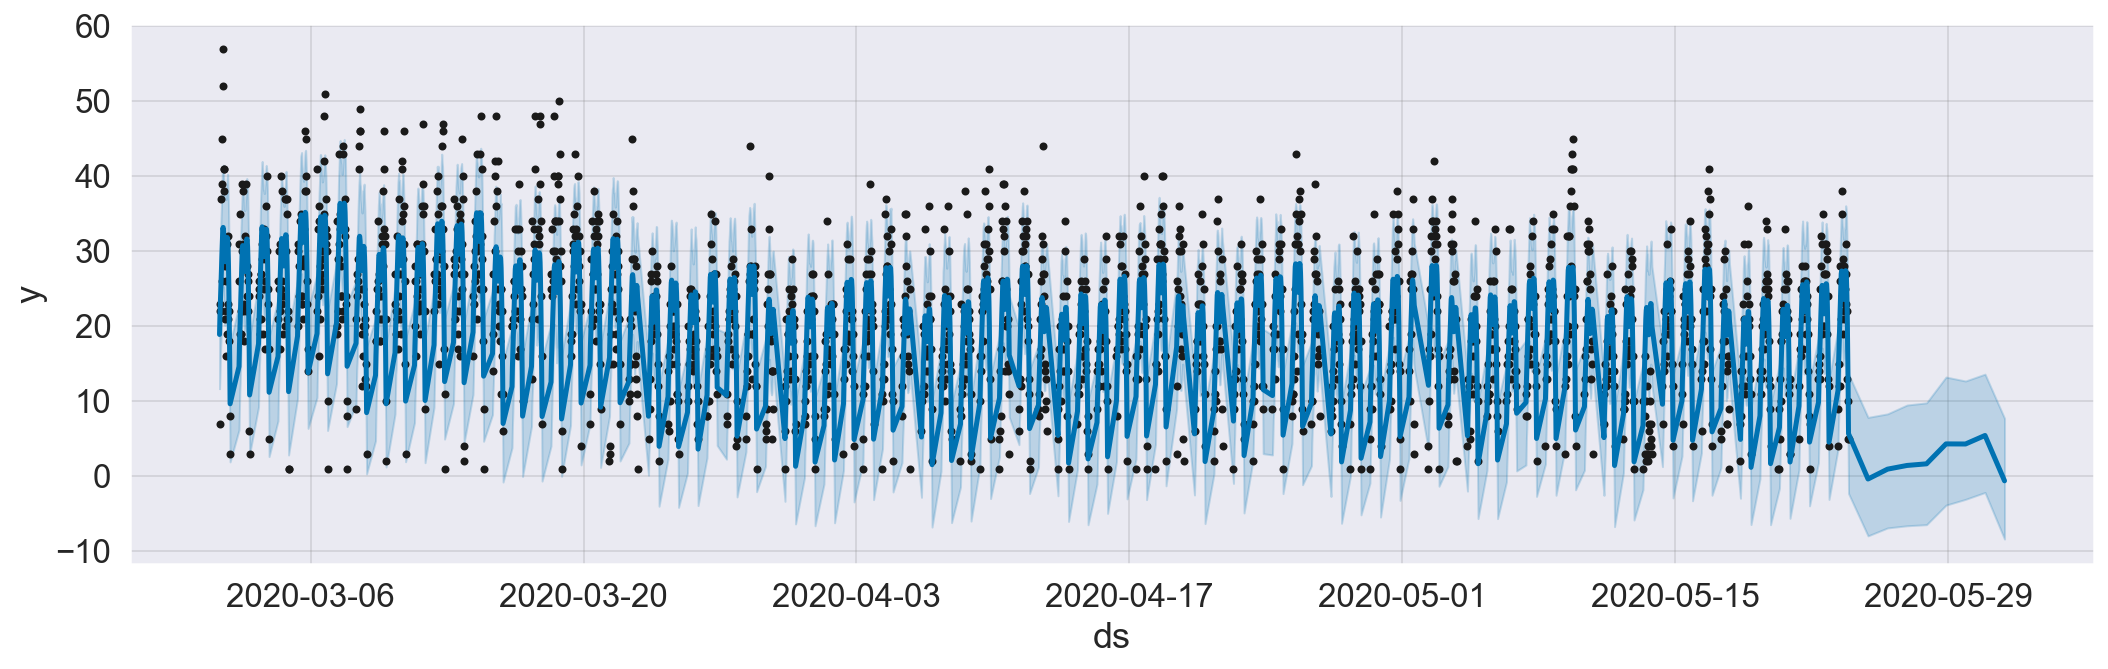

In [21]:
plt,fig_forecast_feriado = dtexp.viewForecastDataframe(forecast_feriados,prophet_feriados,f,ax)
plt.show()

# Visualizando os componentes do modelo

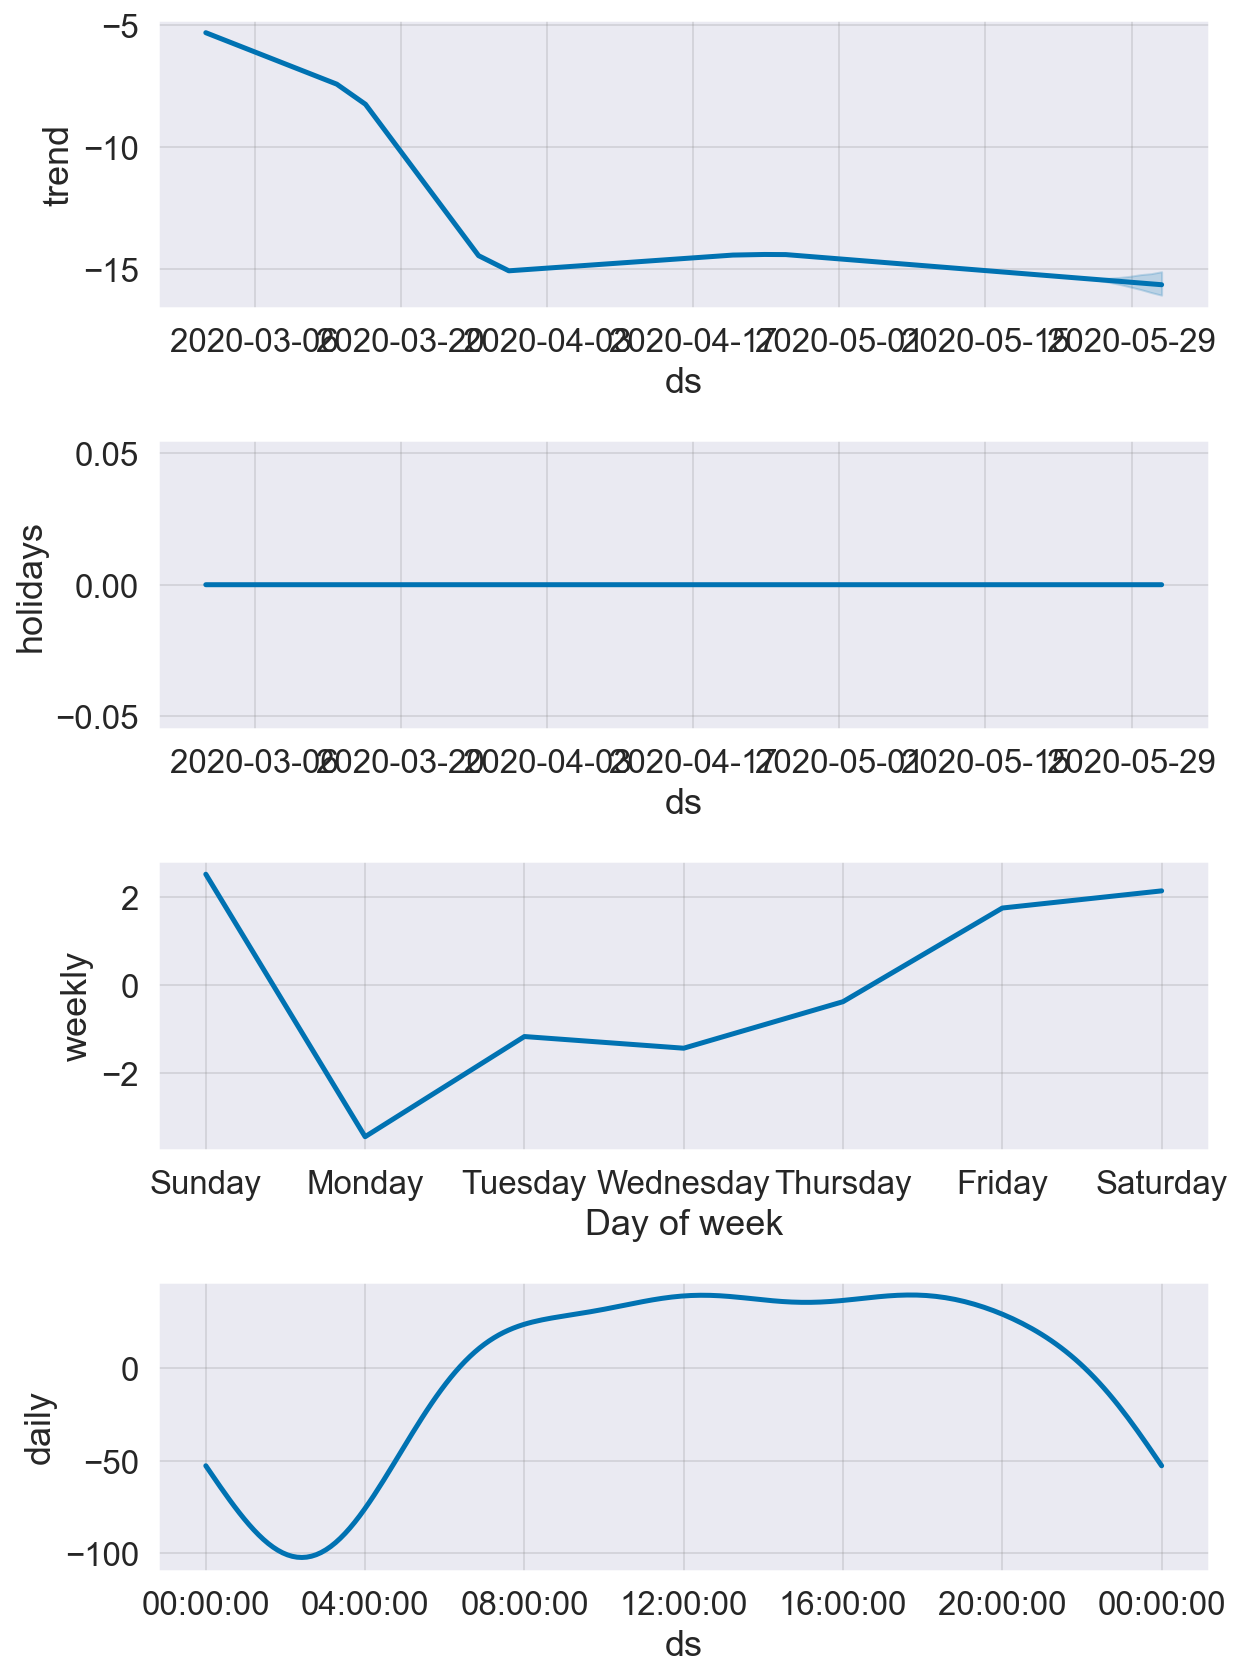

In [22]:
fig_forecast_feriado = prophet_feriados.plot_components(forecast_feriados)

## Visualizar tabela de previsão de teste

In [23]:
forecast_teste_feriados = prophet_feriados.predict(df_432_cli_teste)
iplot(dtexp.viewDataframeAsTable(forecast_teste_feriados))

## Visualizar dataframe de teste previsto e original com feriados

In [24]:
iplot(dtexp.viewCompareDataframes(
    df_432_cli_teste,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [25]:
mape_com_feriados = dtexp.mean_absolute_percentage_error(df_432_cli_teste.y,forecast_teste_feriados.yhat)
print("MAPE",round(mape_com_feriados,4))

MAPE 48.271


In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
                   'changepoint_prior_scale':[15,20,25],
                   'seasonality_prior_scale':[15,20,25],
                   'holidays_prior_scale':[15,20,25],
                   'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

In [30]:
dtexp.tuning_model(df_432_cli_treino,df_432_time_cli,periodo=213,frequencia='D',loja='432',tipo='cliente')

{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 93.48267400555508
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 93.48267400555508
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 93.48267400555508
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 6084.752112586694
{'changepoint_prior_scale': 15, 'h

Mean Absolute Percentage Error(MAPE)------------------------------------ 5177.669204553901
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 5177.669204553901
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 93.48267400555508
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 93.48267400555508
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAP

Mean Absolute Percentage Error(MAPE)------------------------------------ 7681.6008146090735
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 15, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7681.6008146090735
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 15, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7681.6008146090735
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 88.47857335127455
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)-

Mean Absolute Percentage Error(MAPE)------------------------------------ 85.86996205279729
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 25, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7681.6008146090735
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 25, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7681.6008146090735
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 25, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 7681.6008146090735
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)-------

Mean Absolute Percentage Error(MAPE)------------------------------------ 89.6618170992323
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 89.6618170992323
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9487.726567659396
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 9487.726567659396
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------

In [31]:
#'model_parameters_432_cliente_new.csv'
parameters_df = pd.read_csv('model_parameters_432_cliente.csv',sep='\t')
parameters_df = parameters_df.sort_values(by=['MAPE'])
parameters_df = parameters_df.reset_index(drop=True)
parameters_df.drop(['Unnamed: 0'],axis=1,inplace=True)
trace_df_parameters=go.Table(header=dict(values=list(parameters_df[['MAPE','Parameters']])),
                            cells=dict(values=[parameters_df.MAPE,
                                               parameters_df.Parameters]))
data=[trace_df_parameters]
fig_df_parameters=go.Figure(data=data)
iplot(fig_df_parameters)

## Treinando o modelo com os melhores parâmetros identificados

+ changepoint_prior_scale= 20 ; 0.1
+ holidays_prior_scale = 25 ; 0.3
+ n_changepoints = 200
+ seasonality_mode = 'multiplicative'
+ seasonality_prior_scale = 15 ; 20

In [33]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 20,
                      holidays_prior_scale = 25,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 15,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)

final_prophet.add_country_holidays(country_name='BR')
final_prophet.fit(df_432_cli_treino)

In [34]:
future_final = final_prophet.make_future_dataframe(periods=122, freq='D')
forecast_final = final_prophet.predict(future_final)
iplot(dtexp.viewDataframeAsTable(forecast_final))

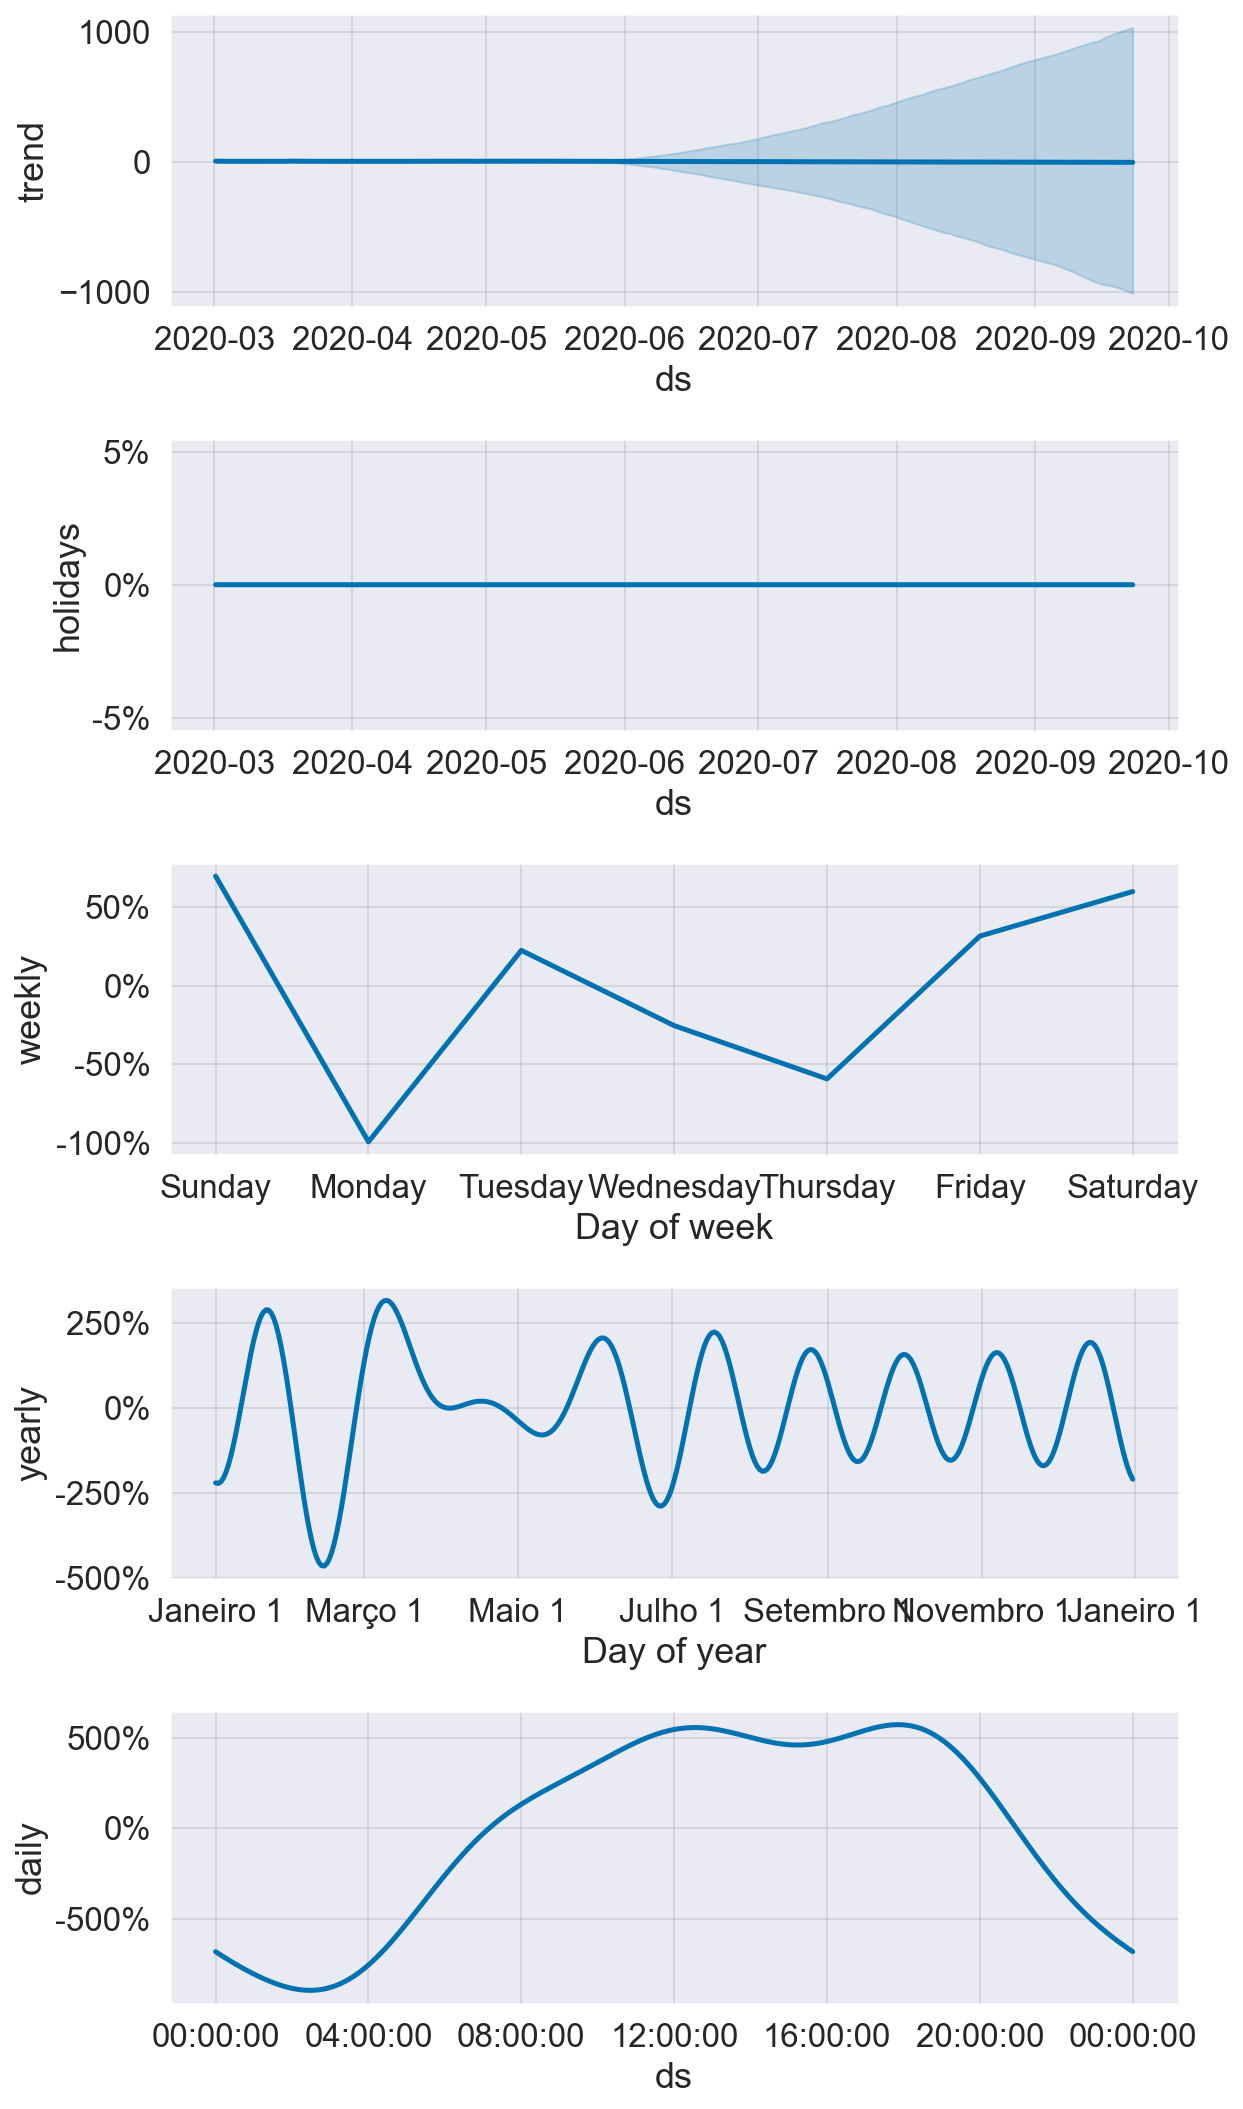

In [35]:
# Plot the components of the model
fig = final_prophet.plot_components(forecast_final)

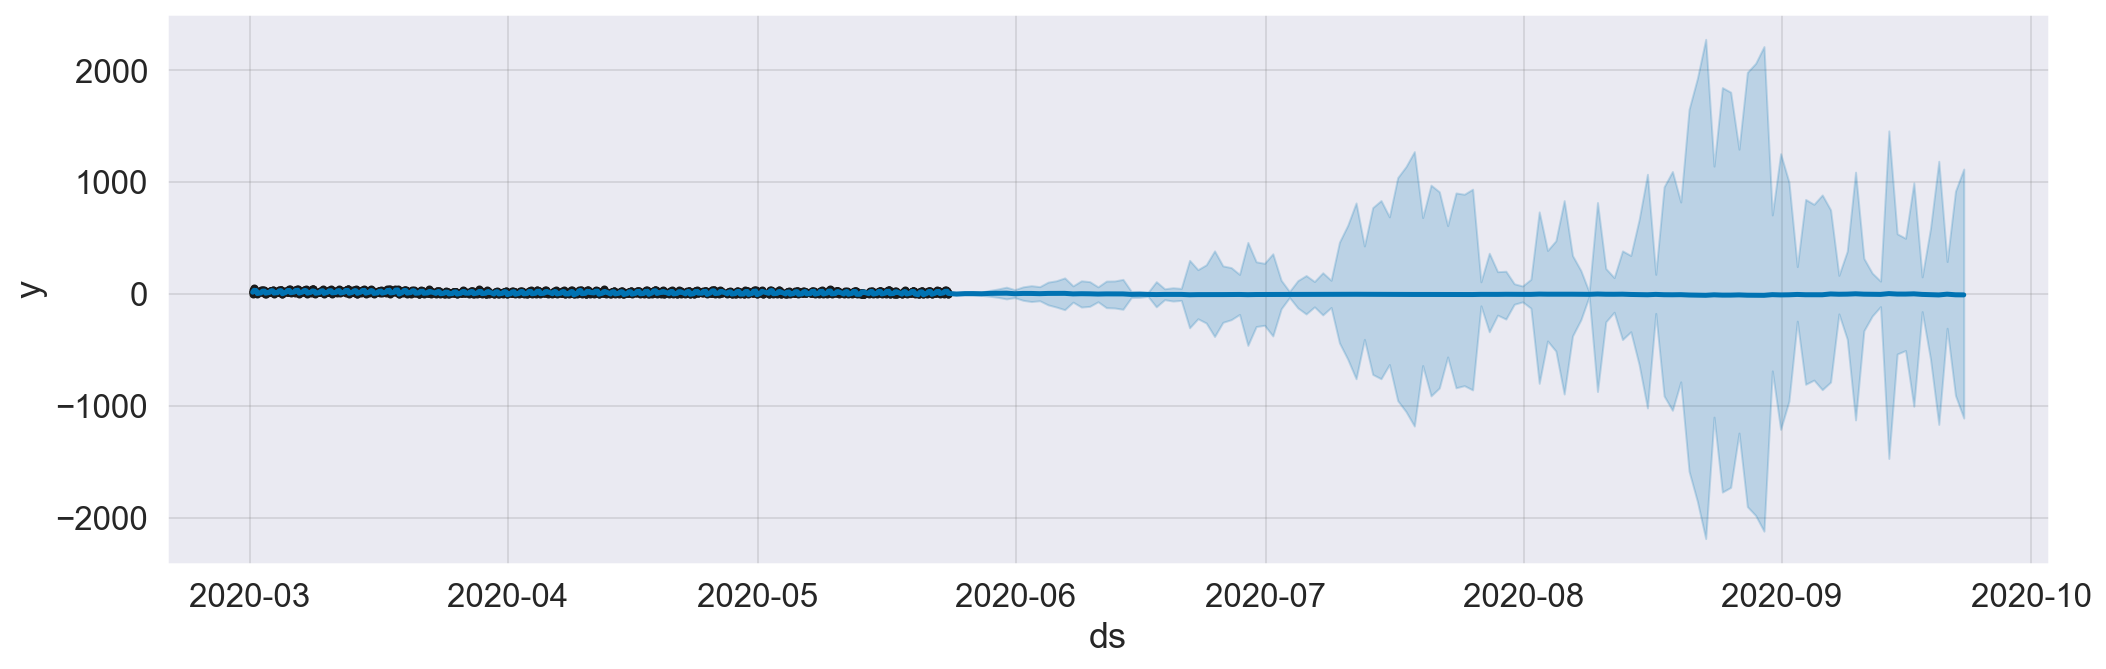

In [36]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet.plot(forecast_final,ax=ax)
plt.show()

In [37]:
df_teste_final= final_prophet.predict(df_432_cli_teste)
iplot(dtexp.viewDataframeAsTable(df_teste_final))

In [38]:
iplot(dtexp.viewCompareDataframes(df_432_cli_teste,
                                   df_teste_final,
                                   title='Qtd Clientes (previsão) vs Qtd Clientes (real)',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [39]:
mape_final = dtexp.mean_absolute_percentage_error(df_432_cli_teste['y'],df_teste_final['yhat'])
print("MAPE",round(mape_final,4))


MAPE 68.8537


# Comparar dados de teste com os dados previstos com gráfico, a fim de verificar os valores e validar o MAPE

